## Reward-effort task simulations

In [283]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [284]:
# Trial numbers (40 mins, 6s per trial, 400 total trials)
num_trials = 400
num_blocks = 8 # 2 action type x 2 global effort state x 2 attentional focus
num_trials_per_block = num_blocks / num_blocks

# Reward and effort levels
outcome_levels_n = np.linspace(-10, 10, 11) 
outcome_levels = outcome_levels_n[outcome_levels_n != 0] # remove 0
effort_levels = np.linspace(5, 10, 6)  


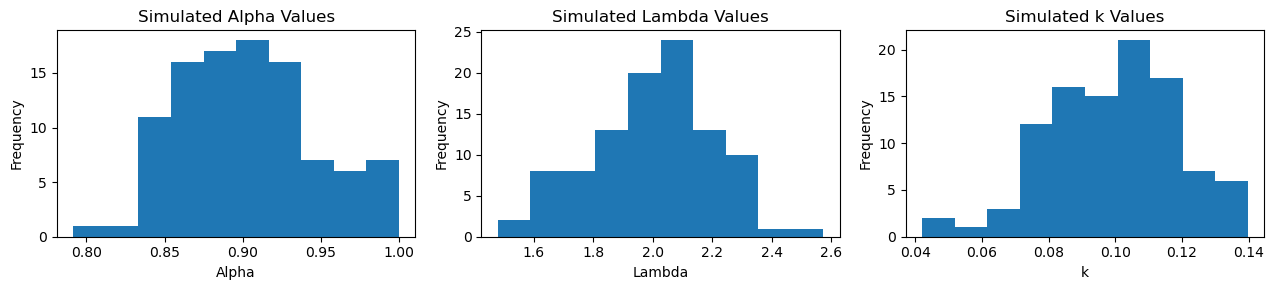

In [285]:
# Simulate participants with different sensitivities - get realistic values from the literature
num_participants = 100

# Specify mean and sd of parameters
alpha_mean, alpha_std = 0.9, 0.05
lambda_mean, lambda_std = 2.0, 0.2
k_mean, k_std = 0.1, 0.02

# Generate parameters from normal distributions
alpha_values = np.random.normal(alpha_mean, alpha_std, num_participants)
lambda_values = np.random.normal(lambda_mean, lambda_std, num_participants)
k_values = np.random.normal(k_mean, k_std, num_participants)

# Ensure parameters are within a reasonable range
alpha_values = np.clip(alpha_values, 0, 1)
lambda_values = np.clip(lambda_values, 1, 3)
k_values = np.clip(k_values, 0, 1)


# Plot histograms of the parameters
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(13, 3))

axes[0].hist(alpha_values)
axes[0].set_title('Simulated Alpha Values')
axes[0].set_xlabel('Alpha')
axes[0].set_ylabel('Frequency')

axes[1].hist(lambda_values)
axes[1].set_title('Simulated Lambda Values')
axes[1].set_xlabel('Lambda')
axes[1].set_ylabel('Frequency')

axes[2].hist(k_values)
axes[2].set_title('Simulated k Values')
axes[2].set_xlabel('k')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

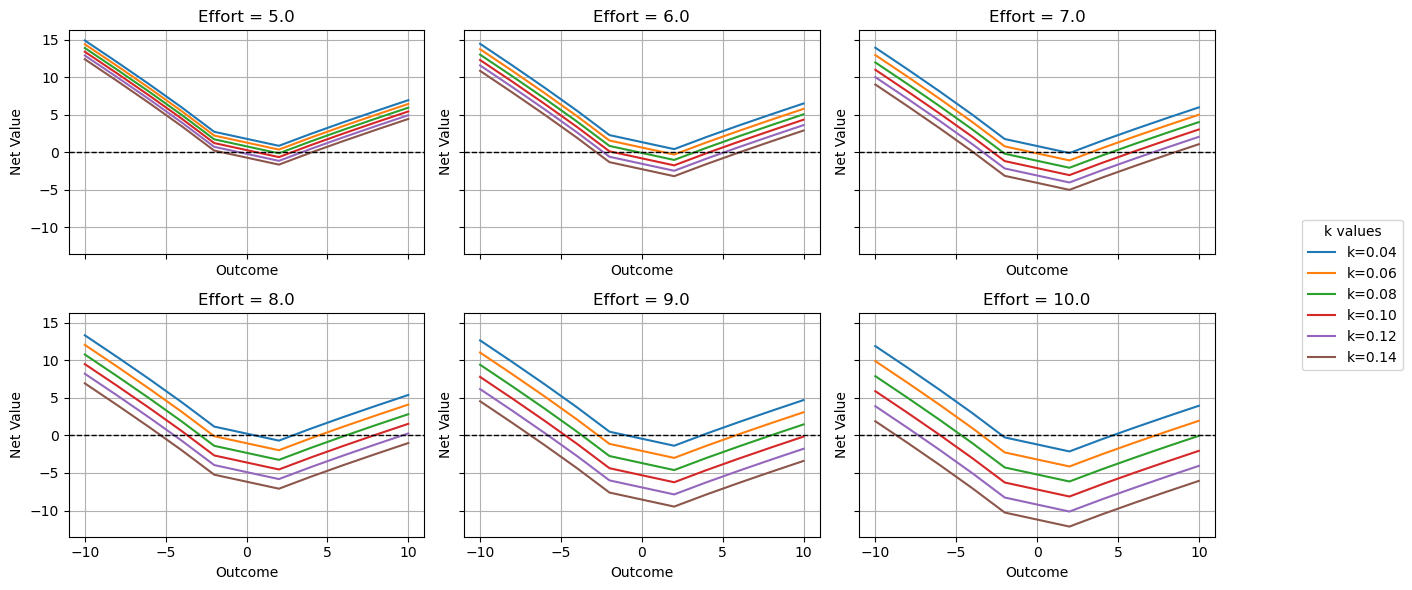

In [292]:
# Function to calculate net value based on outcome, effort, reward sensitivity alpha, loss sensitivty beta, effort sensitivity k, and loss aversion lambda
def calculate_net_value(outcome, effort, alpha, k, lambda_):
    if outcome >= 0:
        return (outcome ** alpha) - k * (effort ** 2)  # positive outcome - effort --> the higher the better
    else:
        return abs(-lambda_ * ((-outcome) ** alpha)) - k * (effort ** 2)  # removing the negative sign from the outcome to get magnitude of (negative) outcome - magnitude of effort --> the higher the less bad (ie better)



# Plot the net value function for different ks at different effort levels, fixing alpha and lambda at their mean values
plot_ks = np.linspace(0.04, 0.14, 6)  # different values for k
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(13, 6), sharex=True, sharey=True)
axes = axes.flatten()
for i, plot_effort in enumerate(effort_levels):
    ax = axes[i]
    for plot_k in plot_ks:
        net_values = [calculate_net_value(outcome, plot_effort, alpha_mean, plot_k, lambda_mean) for outcome in outcome_levels]
        ax.plot(outcome_levels, net_values, label=f'k={plot_k:.2f}')
    ax.set_title(f'Effort = {plot_effort}')
    ax.set_xlabel('Outcome')
    ax.set_ylabel('Net Value')
    ax.axhline(0, color='black', lw=1, linestyle='--')
    ax.grid(True)
    if i == 0: 
        fig.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title="k values")
plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

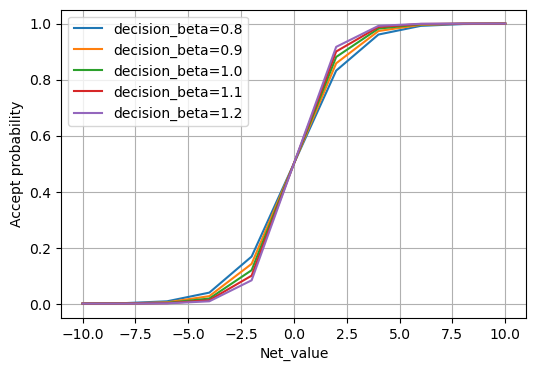

In [287]:
# Logistic function to get choice probabilities
decision_beta = 0.9  
def logistic_choice_prob(net_value, decision_beta):
    return 1 / (1 + np.exp(-decision_beta * net_value))


# Plot the Logistic function for different betas
plot_betas = np.linspace(0.8, 1.2, 5)
plt.figure(figsize=(6, 4))
for b in plot_betas:
    plt.plot(outcome_levels_n, logistic_choice_prob(outcome_levels_n, b), label=f'decision_beta={b:.1f}')
plt.xlabel('Net_value')
plt.ylabel('Accept probability')
plt.legend()
plt.grid(True)
plt.show()

In [288]:
# Generate stimuli and responses
stimuli = []
responses = []

for outcome in outcome_levels:
    for effort in effort_levels:
        # Calculate net values for all participants
        net_values = np.array([calculate_net_value(outcome, effort, alpha, k, lambda_)
                               for alpha, k, lambda_ in zip(alpha_values, k_values, lambda_values)])
        
        # Apply logistic function to calculate acceptance probabilities
        probabilities = logistic_choice_prob(net_values, decision_beta)
        
        # Simulate binary choices (accept/reject) based on probabilities
        choices = np.random.binomial(1, probabilities)
        
        # Store stimuli and responses
        stimuli.append((outcome, effort))
        responses.append(choices)

# Convert responses to numpy array
responses = np.array(responses)



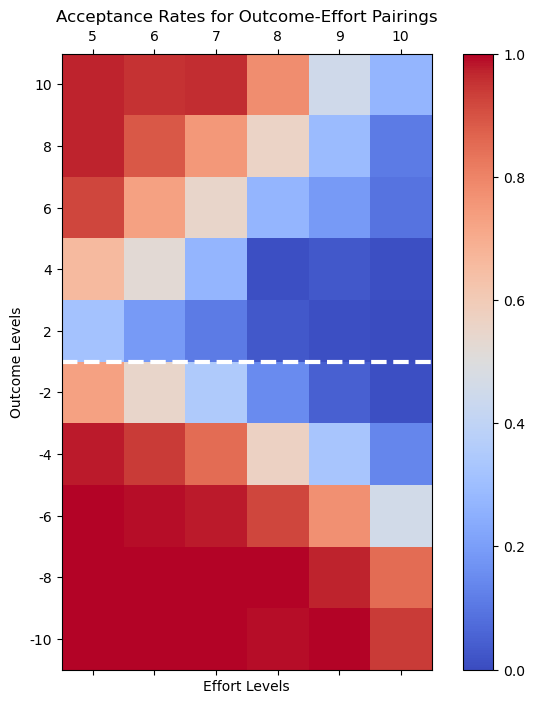

In [289]:
# Visualizing the acceptance rates for each reward-effort pairing across all participants
# Matrix looks asymmetric because of loss aversion
acceptance_rates = responses.mean(axis=1)

# Reshape acceptance rates for plotting 
# acceptance_rates is a 1D array representing the mean acceptance rates across all participants for each reward-effort pairing
# reshaped acceptance_matrix is a 2D array where rows represent different outcome levels and columns represent different effort levels
acceptance_matrix = acceptance_rates.reshape(len(outcome_levels), len(effort_levels))

fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(acceptance_matrix, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(np.arange(len(effort_levels)))
ax.set_yticks(np.arange(len(outcome_levels)))
ax.set_xticklabels(effort_levels.astype(int))
ax.set_yticklabels(outcome_levels.astype(int))
ax.invert_yaxis()

# Add dotted horizontal lines at the positions for outcome = 2 and outcome = -2
lowest_reward_index = np.where(outcome_levels == 2)[0][0]
ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=3)


plt.xlabel('Effort Levels')
plt.ylabel('Outcome Levels')
plt.title('Acceptance Rates for Outcome-Effort Pairings')
plt.show()


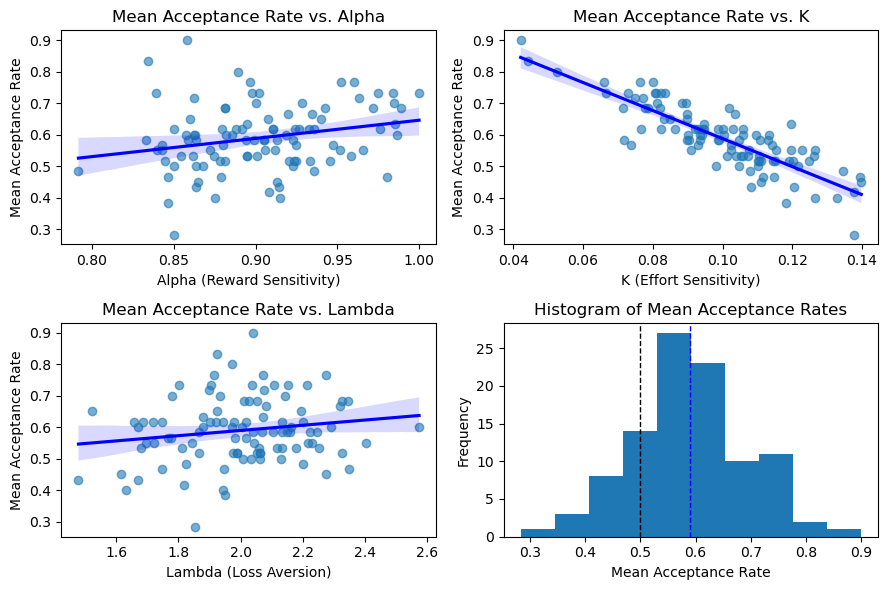

In [290]:
# Calculate mean acceptance rates
mean_acceptance_rates = responses.mean(axis=0)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# Plot for Alpha vs. Mean Acceptance Rate
sns.regplot(x=alpha_values, y=mean_acceptance_rates, ax=axs[0, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[0, 0].set_xlabel('Alpha (Reward Sensitivity)')
axs[0, 0].set_ylabel('Mean Acceptance Rate')
axs[0, 0].set_title('Mean Acceptance Rate vs. Alpha')

# Plot for K vs. Mean Acceptance Rate
sns.regplot(x=k_values, y=mean_acceptance_rates, ax=axs[0, 1], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[0, 1].set_xlabel('K (Effort Sensitivity)')
axs[0, 1].set_ylabel('Mean Acceptance Rate')
axs[0, 1].set_title('Mean Acceptance Rate vs. K')

# Plot for Lambda vs. Mean Acceptance Rate
sns.regplot(x=lambda_values, y=mean_acceptance_rates, ax=axs[1, 0], scatter_kws={'alpha':0.6}, line_kws={'color':'blue'})
axs[1, 0].set_xlabel('Lambda (Loss Aversion)')
axs[1, 0].set_ylabel('Mean Acceptance Rate')
axs[1, 0].set_title('Mean Acceptance Rate vs. Lambda')

# Plot histogram of mean acceptance rates --> give offers such that mean acceptance rate plot will be around 0.5! currently sampling every stimulus combination once
axs[1, 1].hist(mean_acceptance_rates)
axs[1, 1].set_xlabel('Mean Acceptance Rate')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].set_title('Histogram of Mean Acceptance Rates')
axs[1, 1].axvline(0.5, color='black', lw=1, linestyle='--')
axs[1, 1].axvline(np.mean(mean_acceptance_rates), color='blue', lw=1, linestyle='--')

plt.tight_layout()
plt.show()

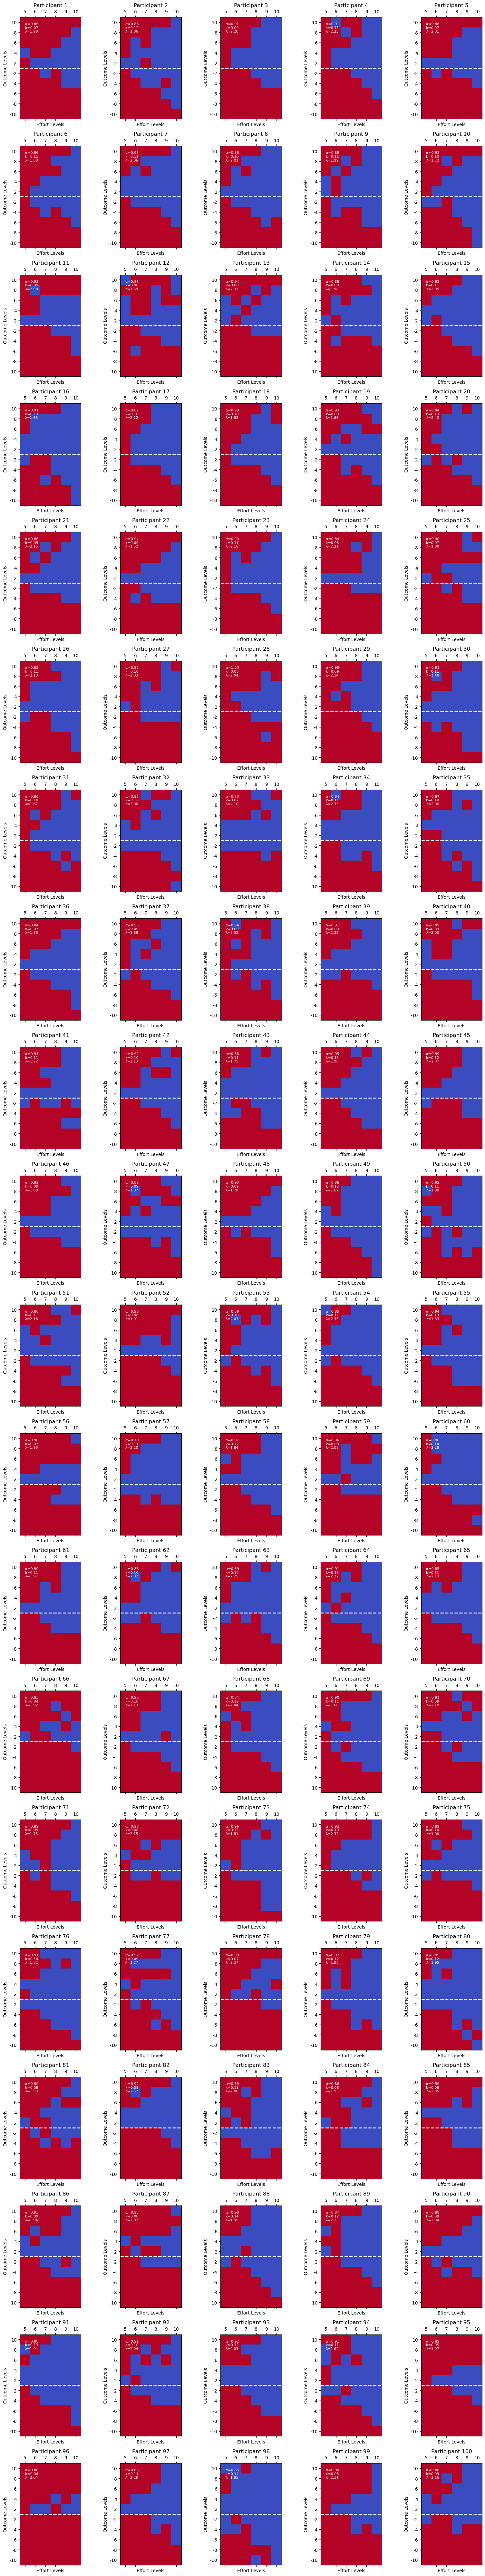

In [291]:
# Visualizing the acceptance rates for each participant separately
num_cols = 5  # Number of plots per row
num_rows = num_participants // num_cols + (1 if num_participants % num_cols else 0)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, num_rows * 4))

for participant_idx in range(num_participants):
    row = participant_idx // num_cols
    col = participant_idx % num_cols
    
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    participant_responses = responses[:, participant_idx]
    acceptance_matrix = participant_responses.reshape(len(outcome_levels), len(effort_levels))
    
    cax = ax.matshow(acceptance_matrix, interpolation='nearest', cmap='coolwarm')
    
    ax.set_xticks(np.arange(len(effort_levels)))
    ax.set_yticks(np.arange(len(outcome_levels)))
    ax.set_xticklabels(effort_levels.astype(int))
    ax.set_yticklabels(outcome_levels.astype(int))
    ax.invert_yaxis()

    # Add dotted horizontal lines at the positions for outcome = 2 and outcome = -2
    lowest_reward_index = np.where(outcome_levels == 2)[0][0]
    ax.axhline(lowest_reward_index - 0.5, color='white', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Effort Levels')
    ax.set_ylabel('Outcome Levels')
    ax.set_title(f'Participant {participant_idx + 1}')

    # Print participant parameters 
    params_text = (f"α={alpha_values[participant_idx]:.2f} \n"
                   f"k={k_values[participant_idx]:.2f} \n"
                   f"λ={lambda_values[participant_idx]:.2f}")
    ax.text(0, len(outcome_levels) - 2, params_text, color='white', fontsize=8)

# Adjust layout
plt.tight_layout()
plt.show()

- generate stimuli around the diagonal 
- check if for most participants with slightly different parameters / some noise we would get reasonable acceptance rates (eg between 25% and 75% or so)
- sample inversely proportional to distance from the 50/50 line
- have effort continuous (e.g. for the top left corner, just have 1 stimulus that covers 4 of the discrete fields as we don't want to sample much there)
- just show effort as a bar that needs to be filled - ie can be continuous
